<a href="https://colab.research.google.com/github/sktexaslearn/MIMIC-Visualization/blob/main/MIMIC_Visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<ipython-input-41-8f4347617443>:20: DtypeWarning:

Columns (8,10,13,14) have mixed types. Specify dtype option on import or set low_memory=False.



Filtered heart rate data rows: 8094
Selected hadm_id: 163189 with rows: 782


<ipython-input-41-8f4347617443>:69: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Total rows in NOTEEVENTS: 0
Non-null TEXT rows: 0
Sample TEXT data: []
Top 5 words and counts: Series([], Name: count, dtype: int64)
No words found in NOTEEVENTS.TEXT. Using fallback data.


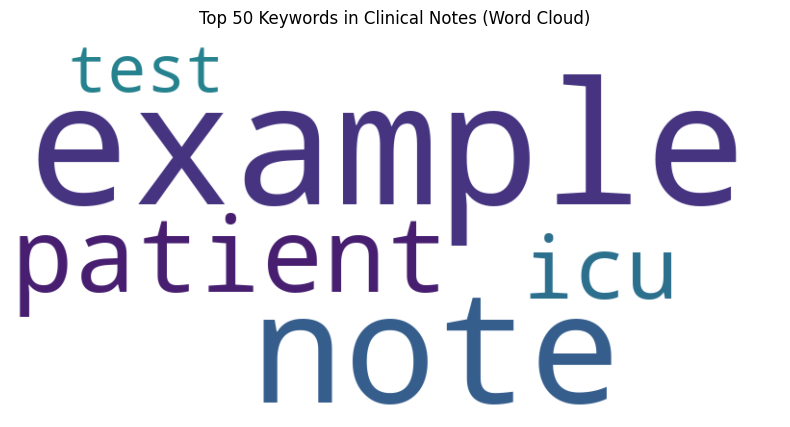

In [ ]:
from google.colab import files
import pandas as pd
import numpy as np
from datetime import datetime
import plotly.express as px
import bokeh.plotting as bk
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.io import output_file, show, output_notebook, push_notebook
import json
from scipy.stats import ttest_ind
from wordcloud import WordCloud
import matplotlib.pyplot as plt


# d1 = files.upload()
labevents = pd.read_csv('LABEVENTS.csv')  # Lab tests

# d2 = files.upload()
chartevents = pd.read_csv('CHARTEVENTS.csv')  # Vital signs

# d3 = files.upload()
prescriptions = pd.read_csv('PRESCRIPTIONS.csv')  # Medications

# d4 = files.upload()
procedureevents = pd.read_csv('PROCEDUREEVENTS_MV.csv')  # Procedures in ICU

# d5 = files.upload()
noteevents = pd.read_csv('NOTEEVENTS.csv')  # Clinical notes

# d6 = files.upload()
outputevents = pd.read_csv('OUTPUTEVENTS.csv')


labevents['CHARTTIME'] = pd.to_datetime(labevents['charttime'])
chartevents['CHARTTIME'] = pd.to_datetime(chartevents['charttime'])
prescriptions['STARTDATE'] = pd.to_datetime(prescriptions['startdate'])
procedureevents['STARTTIME'] = pd.to_datetime(procedureevents['starttime'])
noteevents['CHARTDATE'] = pd.to_datetime(noteevents['chartdate'])
outputevents['CHARTTIME'] = pd.to_datetime(outputevents['charttime'])

# 1. Box Plot: (LABEVENTS)
glucose_labs = labevents[labevents['itemid'].isin([50809, 50931]) & labevents['valuenum'].notna()]
fig = px.box(glucose_labs, x='itemid', y='valuenum', title='Glucose Lab Values Distribution',
             labels={'itemid': 'Lab Test (itemid)', 'valuenum': 'Value (mg/dL)'})
fig.update_layout(width=800, height=600)
fig.show()

# 2. Bokeh Time Series: (CHARTEVENTS)
# Filter for heart rate (ITEMID ~ 220045)
hr_data = chartevents[chartevents['itemid'] == 220045].dropna(subset=['valuenum'])
print("Filtered heart rate data rows:", hr_data.shape[0])

if hr_data.empty:
    print("No heart rate data found for itemid 220045. Check CHARTEVENTS.csv.")
else:
    # Select a valid hadm_id
    hadm_counts = hr_data['hadm_id'].value_counts()
    if hadm_counts.empty or hadm_counts.max() < 10:
        print("No hadm_id with enough data points. Using first available.")
        valid_hadm = hr_data['hadm_id'].iloc[0]
    else:
        valid_hadm = hadm_counts[hadm_counts > 10].index[0]
    hr_sample = hr_data[hr_data['hadm_id'] == valid_hadm]
    print("Selected hadm_id:", valid_hadm, "with rows:", hr_sample.shape[0])

  # 'charttime'  in datetime format
    hr_sample['charttime'] = pd.to_datetime(hr_sample['charttime'])

    # Prepare data for Bokeh
    source = ColumnDataSource({'time': hr_sample['charttime'], 'hr': hr_sample['valuenum']})

    # Create plot
    p = bk.figure(title=f"Heart Rate Over Time (hadm_id: {valid_hadm})",
                  x_axis_type='datetime',
                  x_axis_label='Time',
                  y_axis_label='Heart Rate (bpm)',
                  width=800, height=600)
    p.line('time', 'hr', source=source, line_width=2, color='red')
    p.add_tools(HoverTool(tooltips=[('Time', '@time{%F %T}'), ('HR', '@hr')],
                          formatters={'@time': 'datetime'}))


    output_notebook()
    show(p, notebook_handle=True)

# 3. Bar Chart: Top Medications by Dose (PRESCRIPTIONS)

prescriptions['dose_val_rx'] = pd.to_numeric(prescriptions['dose_val_rx'], errors='coerce')
top_drugs = prescriptions.groupby('drug').agg({'dose_val_rx': 'sum'}).nlargest(10, 'dose_val_rx').reset_index()
fig = px.bar(top_drugs, x='drug', y='dose_val_rx', title='Top 10 Medications by Total Dose',
             labels={'dose_val_rx': 'Total Dose (Units)'})
fig.update_layout(width=800, height=600)
fig.show()

# 4. Violin Plot: (PROCEDUREEVENTS_MV)
procedureevents['endtime'] = pd.to_datetime(procedureevents['endtime'])
procedureevents['starttime'] = pd.to_datetime(procedureevents['starttime'])

procedureevents['duration'] = (procedureevents['endtime'] - procedureevents['starttime']).dt.total_seconds() / 3600
proc_sample = procedureevents[procedureevents['itemid'].isin(procedureevents['itemid'].value_counts().head(5).index)]
fig = px.violin(proc_sample, x='itemid', y='duration', title='Procedure Duration by Type',
                labels={'itemid': 'Procedure (itemid)', 'duration': 'Duration (Hours)'})
fig.update_layout(width=800, height=600)
fig.show()

# 5: Stacked Bar Chart (OUTPUTEVENTS)
# Filter common output types
outputevents['day'] = pd.to_datetime(outputevents['charttime'], errors='coerce').dt.date
output_data = outputevents[outputevents['itemid'].isin(outputevents['itemid'].value_counts().head(5).index)]
output_summary = output_data.groupby(['day', 'itemid'])['value'].sum().unstack().fillna(0)

# Transpose
output_summary_t = output_summary.T

# Create heatmap
fig = px.imshow(output_summary_t,
                x=output_summary_t.columns,
                y=output_summary_t.index,
                labels=dict(x="date", y="Output Type (itemid)", color="Volume (mL)"),
                title='Daily Output Volumes by Type (Heatmap)',
                color_continuous_scale='Viridis')
fig.update_layout(width=800, height=600)
fig.show()

# 6: Word Cloud (NOTEEVENTS)

print("Total rows in NOTEEVENTS:", len(noteevents))
print("Non-null TEXT rows:", noteevents['text'].notna().sum())
notes_text = noteevents['text'].dropna()
print("Sample TEXT data:", notes_text.head().tolist())

# Generate word frequencies
notes_sample = notes_text.str.lower().str.split().explode().value_counts().head(50)
print("Top 5 words and counts:", notes_sample.head())

if notes_sample.empty:
    print("No words found in NOTEEVENTS.TEXT. Using fallback data.")
    word_freq = {'example': 10, 'note': 8, 'patient': 6, 'icu': 4, 'test': 2}
else:
    word_freq = dict(notes_sample)

# Create and display word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate_from_frequencies(word_freq)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Top 50 Keywords in Clinical Notes (Word Cloud)')
plt.show()